In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
import pandas as pd
from pytz import utc
import os
import mlflow
import numpy as np

# mlflow imports
from mlflow.models.signature import infer_signature

# sklearn imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# oma_tracking imports
from oma_tracking.data.utils import read_simulations_csv_files
from oma_tracking.data import make_dataset
from oma_tracking.data.preprocessing import AngleTransformer, sin_cos_angle_inputs
import oma_tracking.models.mlflow_functions as mlflow_f


from dotenv import load_dotenv
load_dotenv()

c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
c:\Users\Max\anaconda3\envs\soiltwin\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


True

In [3]:
start =  datetime.datetime(2022,11,1,tzinfo=utc)
stop  = datetime.datetime(2023,3,1,tzinfo=utc)
location = 'nw2c02'
name_location = 'NW2_C02'

home_folder = "../../../"
# Data Paths
data_file_name = '_'.join([location, start.strftime("%Y%m%d"), stop.strftime("%Y%m%d")])
data_path = home_folder + "data/nw2/raw/" + data_file_name + ".parquet"
mvbc_path = home_folder + "data/nw2/mvbc_data.parquet"
tracked_frequencies_path = home_folder + "data/nw2/tracked_modes/harmonics_removed/" + location + ".parquet"
simulations_data_path = home_folder + "data/nw2/simulations/" + location + "/"

# Get all the data
data = pd.read_parquet(data_path)
mvbc_data = pd.read_parquet(mvbc_path)
tracked_frequencies = pd.read_parquet(tracked_frequencies_path)
#simulation_data = read_simulations_csv_files(simulations_data_path + "eigen_frequencies/")
#simulation_shifts = read_simulations_csv_files(simulations_data_path + "mean_shifts/")
#simulation_errors = pd.read_csv(simulations_data_path + "errors/Errors_No_scour.csv", index_col=0)

In [4]:
AZURE_STORAGE_ACCESS_KEY = os.getenv('AZURE_STORAGE_ACCESS_KEY')
AZURE_STORAGE_CONNECTION_STRING = os.getenv('AZURE_STORAGE_CONNECTION_STRING')
MLFLOW_TRACKING_URI = os.getenv('MLFLOW_TRACKING_URI')

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

artifact_root = 'wasbs://test@mlflowstoragev1.blob.core.windows.net'
mlflow_ui_string = mlflow_f.create_mlflow_ui(MLFLOW_TRACKING_URI, artifact_root)
database_url = 'http://127.0.0.1:5000'
mlflow_f.connect_mlflow_ui(mlflow_ui_string, database_url)

experiment_name = 'NW2_scour'
experiment = mlflow_f.run_mlflow_experiment(experiment_name = experiment_name)

c:\users\max\documents\owi_lab\code\packages\oma_tracking\oma_tracking\models\mlflow_functions.py:124: UserWarning: Mlflow_tracking_uri passed without checking checking username for ':' and '@' symbols. Manually control the uri!
  warnings.warn(


mlflow experiment set to: NW2_scour


In [5]:
weather_inputs = make_dataset.get_weather_subset(mvbc_data)
scada_inputs = make_dataset.get_scada_subset(data)

inputs = \
    pd.concat(
        [
            weather_inputs,
            scada_inputs
        ],
        axis=1
    )

prediction_params = \
    tracked_frequencies 

In [6]:
from oma_tracking.models.utils import convert_dict
hyperopt_folder = home_folder + "data/nw2/model_hyperopt/removed_harmonics/" + location + "_"

XGB_optimizations = convert_dict(pd.read_csv(hyperopt_folder + "xgb_optimizations.csv", index_col=0))
RF_optimizations = convert_dict(pd.read_csv(hyperopt_folder + "rf_optimizations.csv", index_col=0))

In [7]:
site = 'NorthWester2'
site_id = 'NW2'
location_id = 'C02'
structure =  'OWT'
type = 'MPE'
model_function = 'normalization'
tags = {
        "site_id": str(site_id),
        "location_id": str(location_id),
        "structure": str(structure),
        "type": str(type)
    }

2023/04/04 11:01:45 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2023/04/04 11:01:47 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/04/04 11:02:30 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2022-02-28; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'oma-tracking'}
2023/04/04 11:02:46 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2023/04/04 11:02:46 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/04/04 11:03:04 WARNING mlflow.utils.requirem

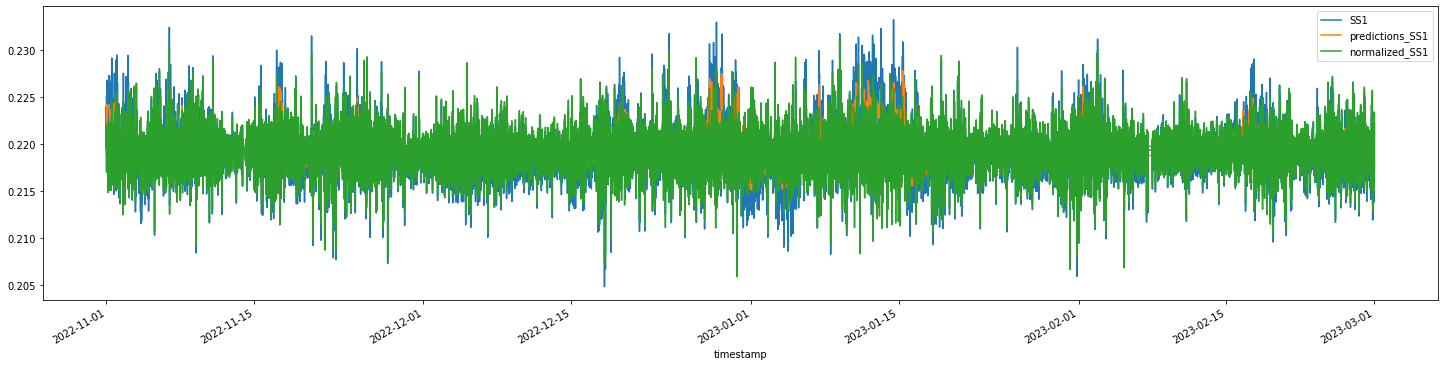

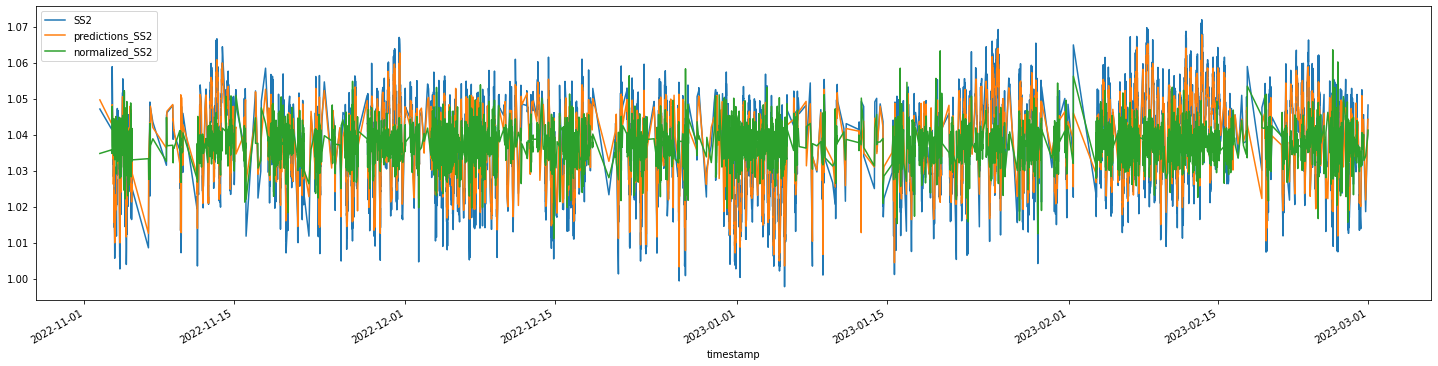

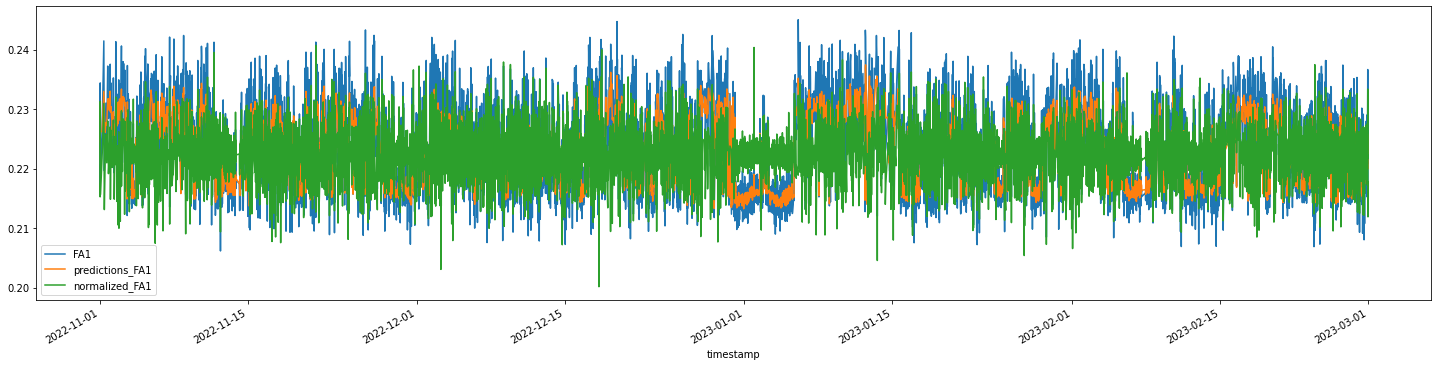

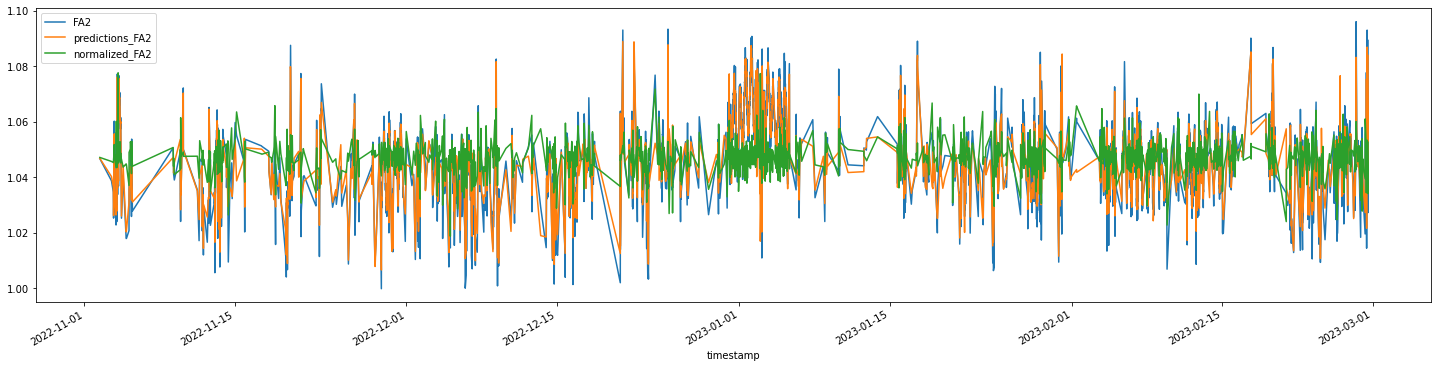

In [8]:
from mlflow.models.signature import infer_signature
from sklearn.ensemble import RandomForestRegressor

# Track Models in MLFlow
test_size = 0.2
random_state = 42
nb_path = os.getcwd()

run_name = \
    '_'.join(
        [
            name_location,
            type,
            model_function,
            datetime.datetime.today().strftime('%Y-%m-%d')
        ]
    )

predictions_inv = pd.DataFrame()
models = {}

for mode in prediction_params.columns:
    with mlflow.start_run(tags=tags, run_name=run_name):
        
        
        mlflow.autolog(log_models=True, exclusive=False)
        y = prediction_params[mode].loc[inputs.index[0]:inputs.index[-1]].dropna()
        X = inputs.loc[y.index].dropna()
        y = y.loc[X.index]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
        
        regr = \
            Pipeline(
                steps=[
                    ('preprocessing_angles', AngleTransformer(angles = ['winddirection', 'yaw'])),
                    ('regressor', RandomForestRegressor(
                        n_estimators = RF_optimizations[mode]['n_estimators'],
                        max_depth = RF_optimizations[mode]['max_depth'],
                        min_samples_leaf = RF_optimizations[mode]['min_samples_leaf'],
                        min_samples_split = RF_optimizations[mode]['min_samples_split']
                        )
                    )
                ]
            )
            
        regr.fit(X_train, y_train)

        models[mode] = regr

        metrics = mlflow.sklearn.eval_and_log_metrics(
                regr, X_test, y_test, prefix="test_"
            )
        
        params = {
                "model function": 'normalization',
                "prediction_parameter": str(mode),
                "time_period": str(start) + ' - ' + str(stop),
                "data_random_state": random_state,
                "test_size": test_size,
                "notebook": nb_path,
                "model": str(regr.steps)
            }
        
        mlflow.log_params(params)
        predictions_mode = pd.DataFrame(
            {'predictions_'+str(mode): regr.predict(X),
            'normalized_'+str(mode): y - regr.predict(X) + np.mean(y)}, index = y.index)
        
        predictions_inv = pd.concat([predictions_inv, predictions_mode], axis = 1)
        pd.concat([y,predictions_mode], axis=1).plot(figsize=(25,6))

        signature = infer_signature(X_test, regr.predict(X_test))
        mlflow.autolog(disable=True)
        mlflow.end_run()

2023/04/04 11:04:44 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2023/04/04 11:04:44 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2023/04/04 11:04:44 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.
2023/04/04 11:04:44 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2023/04/04 11:04:44 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessing_angles', AngleTransformer(angles=['winddirection', 'yaw'])), ('regressor', XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample

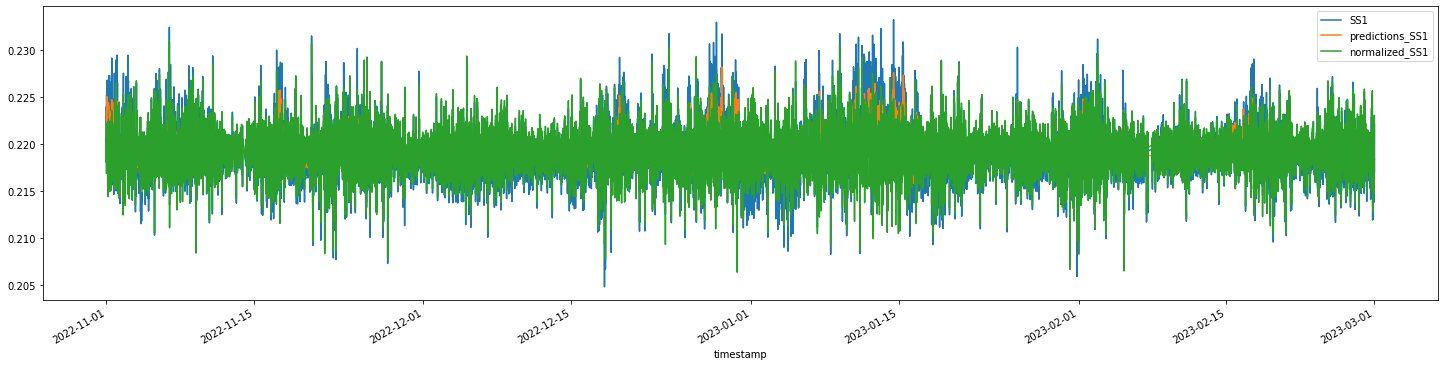

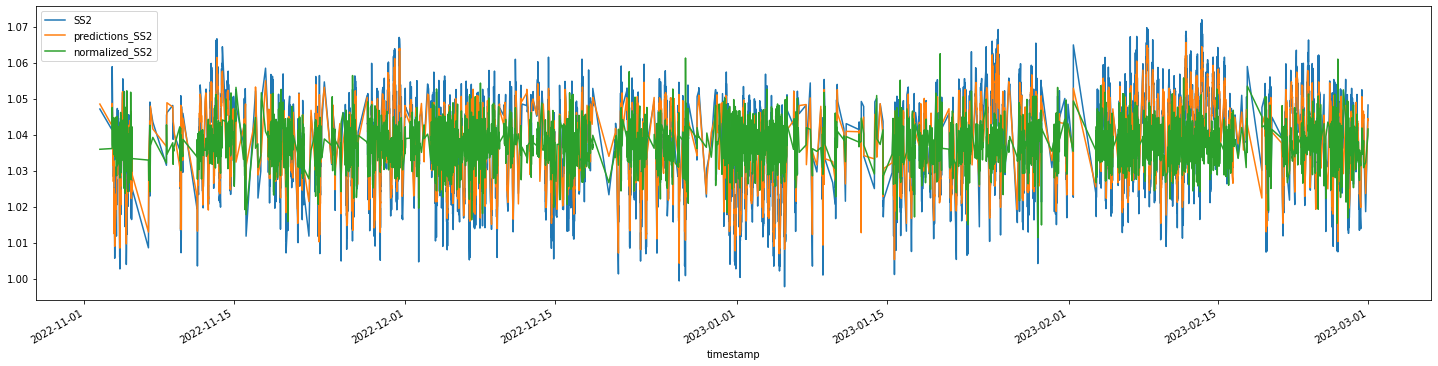

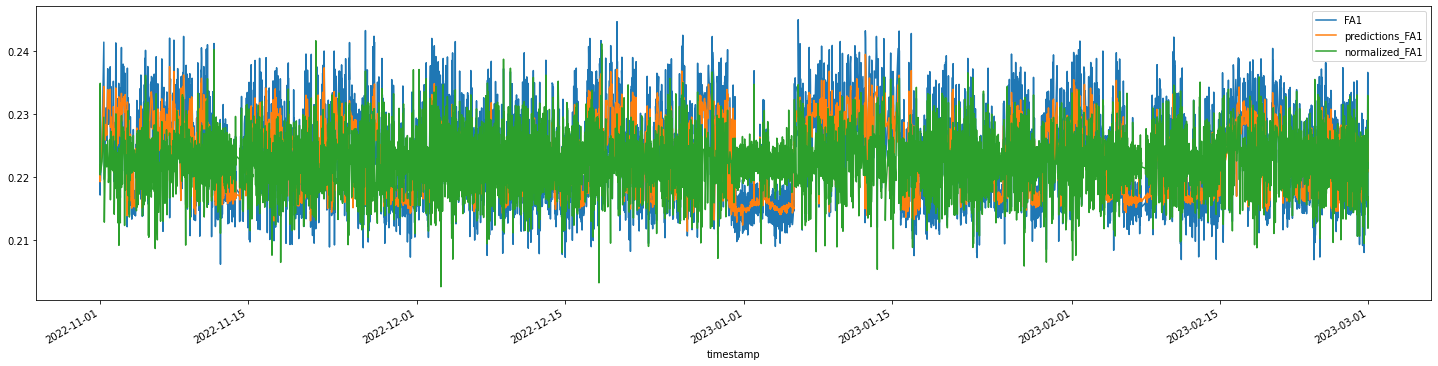

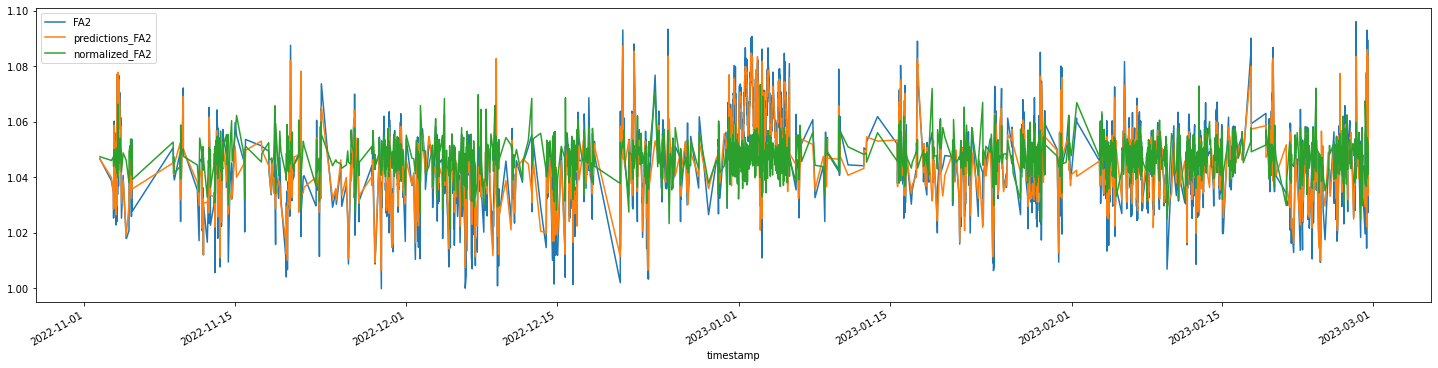

In [9]:
from xgboost import XGBRegressor

# Track Models in MLFlow
test_size = 0.2
random_state = 42
nb_path = os.getcwd()

run_name = \
    '_'.join(
        [
            name_location,
            type,
            model_function,
            datetime.datetime.today().strftime('%Y-%m-%d')
        ]
    )

predictions_inv = pd.DataFrame()
models = {}

for mode in prediction_params.columns:
    with mlflow.start_run(tags=tags, run_name=run_name):
        
        mlflow.autolog(log_models=True, exclusive=False)
        y = prediction_params[mode].loc[inputs.index[0]:inputs.index[-1]].dropna()
        X = inputs.loc[y.index].dropna()
        y = y.loc[X.index]
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=test_size, random_state=random_state)
        
        regr = \
            Pipeline(
                steps=[
                    ('preprocessing_angles', AngleTransformer(angles = ['winddirection', 'yaw'])),
                    ('regressor', XGBRegressor(
                        n_estimators = XGB_optimizations[mode]['n_estimators'],
                        max_depth = XGB_optimizations[mode]['max_depth'],
                        learning_rate = XGB_optimizations[mode]['learning_rate'],
                        colsample_bytree = XGB_optimizations[mode]['colsample_bytree'],
                        )
                    )
                ]
            )
            
        regr.fit(X_train, y_train)

        models[mode] = regr

        metrics = mlflow.sklearn.eval_and_log_metrics(
                regr, X_test, y_test, prefix="test_"
            )
        
        params = {
                "model function": 'normalization',
                "prediction_parameter": str(mode),
                "time_period": str(start) + ' - ' + str(stop),
                "data_random_state": random_state,
                "test_size": test_size,
                "notebook": nb_path,
                "model": str([step[1].__class__ for step in regr.steps])
            }
        
        mlflow.log_params(params)
        predictions_mode = pd.DataFrame(
            {
                'predictions_'+str(mode): regr.predict(X),
                'normalized_'+str(mode): y - regr.predict(X) + np.mean(y)
            },
            index = y.index
        )
        
        predictions_inv = pd.concat([predictions_inv, predictions_mode], axis = 1)
        pd.concat([y,predictions_mode], axis=1).plot(figsize=(25,6))

        mlflow.autolog(disable=True)
        mlflow.end_run()